In [ ]:
!pip install pyforest
from pyforest import *
import warnings
!pip install quandl
import quandl
from pandas import DataFrame
!pip install tscv
from tscv import GapKFold
!pip install backtrader
import backtrader as bt
from backtrader.feeds import PandasData
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
!pip install strategies
from strategies import *
import traceback
import sys, logging, json, pprint, requests
from google.colab import files
!pip install pyfolio
import pyfolio as pf
import unittest
# ONNX run-tine
!pip install skl2onnx
!pip install onnxruntime
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

In [2]:
def NaturalGasData():
  NaturalGas = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") 
  NaturalGas = NaturalGas.loc['2010-01-01':,]
  NaturalGas = NaturalGas [['Open', 'High', 'Low', 'Last', 'Settle', 'Volume']].copy()
  NaturalGas.rename(columns ={'Last': 'Close', 'Settle': 'Adj Close'}, inplace=True)
 
  return NaturalGas

NaturalGas = NaturalGasData()
# NaturalGas.reset_index(inplace=True)
NaturalGas.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-12,2.669,2.693,2.584,2.598,2.600,103531.0
2021-03-15,2.558,2.561,2.478,2.498,2.484,141386.0
2021-03-16,2.494,2.566,2.479,2.562,2.562,91574.0
2021-03-17,2.562,2.565,2.489,2.521,2.528,88133.0
2021-03-18,2.523,2.526,2.422,2.484,2.481,139743.0


In [3]:
NaturalGas.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5.705,5.894,5.705,5.884,5.884,59409.0
2010-01-06,5.690,6.075,5.650,6.009,6.009,99492.0
2010-01-07,6.033,6.108,5.763,5.806,5.806,140611.0
2010-01-08,5.827,5.853,5.621,5.749,5.749,135113.0
2010-01-11,5.576,5.625,5.371,5.454,5.454,101153.0


In [4]:
# count = np.isinf(NaturalGas).values.sum() 
# print("It contains " + str(count) + " infinite values") 

# print("printing column name where infinity is present") 
# col_name = NaturalGas.columns.to_series()[np.isinf(NaturalGas).any()] 
# print(col_name) 

# print("printing row index with infinity ") 
  
# r = NaturalGas.index[np.isinf(NaturalGas).any(1)] 
# print(r)

We will create the signal based on the values of the column, daily_difference. If the value is positive, we will give the value 1, otherwise, the value will remain 0:

In [5]:
def ClassificationCondition():
  df = NaturalGas.copy()
  df['closeReturn'] = df['Close'].pct_change()
  df['highReturn'] = df['High'].pct_change()
  df['lowReturn'] = df['Low'].pct_change() 
  df['volReturn'] = df['Volume'].pct_change() 
  df['dailyChange'] = (df['Close'] - df['Open']) / df['Open']
  df['priceDirection'] = (df['Close'].shift(-1) - df['Close'])
  df = df.replace([np.inf, -np.inf], np.nan)
  df['signal'] = 0.0
  df['signal'] = np.where((df.loc[:,'priceDirection'] > 0), 1.0, 0.0)
  df.drop( columns = 
                        ['Open', 'High', 'Low', 
                         'Close', 'Adj Close','Volume', 
                         'priceDirection'
                        ], axis=1, inplace=True)
  df.dropna(inplace=True)
  return df

df = ClassificationCondition()
df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,closeReturn,highReturn,lowReturn,volReturn,dailyChange,signal
Date,,,,,,
2010-01-06,0.021244,0.030709,-0.009641,0.674696,0.056063,0.0
2010-01-07,-0.033783,0.005432,0.020000,0.413290,-0.037626,0.0
2010-01-08,-0.009817,-0.041749,-0.024640,-0.039101,-0.013386,0.0
2010-01-11,-0.051313,-0.038954,-0.044476,-0.251345,-0.021879,1.0
2010-01-12,0.025119,-0.003556,-0.003165,0.194142,0.019325,1.0
...,...,...,...,...,...,...
2021-03-12,-0.027331,-0.007738,-0.019727,-0.119410,-0.026602,0.0
2021-03-15,-0.038491,-0.049016,-0.041022,0.365639,-0.023456,1.0
2021-03-16,0.025620,0.001952,0.000404,-0.352312,0.027265,0.0


In [6]:
# df['signal'] = df['signal'].diff()
# df

In [7]:
def features():
  X = df.drop( columns = ['signal'], axis=1)
  y = df.signal
  return X,y

X,y = features()
X

,closeReturn,highReturn,lowReturn,volReturn,dailyChange
Date,,,,,
2010-01-06,0.021244,0.030709,-0.009641,0.674696,0.056063
2010-01-07,-0.033783,0.005432,0.020000,0.413290,-0.037626
2010-01-08,-0.009817,-0.041749,-0.024640,-0.039101,-0.013386
2010-01-11,-0.051313,-0.038954,-0.044476,-0.251345,-0.021879
2010-01-12,0.025119,-0.003556,-0.003165,0.194142,0.019325
...,...,...,...,...,...
2021-03-12,-0.027331,-0.007738,-0.019727,-0.119410,-0.026602
2021-03-15,-0.038491,-0.049016,-0.041022,0.365639,-0.023456
2021-03-16,0.025620,0.001952,0.000404,-0.352312,0.027265


In [8]:
MLDataFrame = NaturalGas.tail(len(X))[['Open', 'High', 'Low','Close', 'Volume']]
MLDataFrame

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-08,5.827,5.853,5.621,5.749,135113.0
2010-01-11,5.576,5.625,5.371,5.454,101153.0
2010-01-12,5.485,5.605,5.354,5.591,120791.0
2010-01-13,5.588,5.785,5.432,5.733,109931.0
2010-01-14,5.754,5.804,5.483,5.588,158387.0
...,...,...,...,...,...
2021-03-12,2.669,2.693,2.584,2.598,103531.0
2021-03-15,2.558,2.561,2.478,2.498,141386.0
2021-03-16,2.494,2.566,2.479,2.562,91574.0


In [9]:
y.describe()

count    2812.000000
mean        0.482219
std         0.499773
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: signal, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

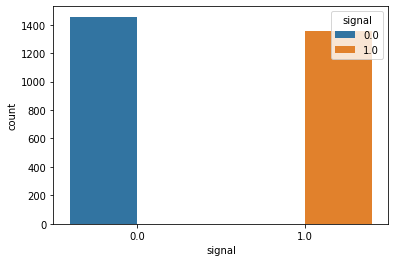

In [10]:
import seaborn as sns
sns.countplot(x = 'signal', data=pd.DataFrame(y), hue='signal')
plt.show()

In [11]:
# X = X.astype(float)

In [12]:
# # Create training and test sets
gkcv = GapKFold(n_splits=10, gap_before=2, gap_after=1)

"""
Introduced gaps between the training and test set to mitigate the temporal dependence.
Here the split function splits the data into Kfolds. 
The test sets are untouched, while the training sets get the gaps removed
"""

for trainIndex, testIndex in gkcv.split(X):
  # print("TRAIN:", trainIndex, "TEST:", testIndex)
  xTrain, xTest = X.values[trainIndex], X.values[testIndex];
  yTrain, yTest = y.values[trainIndex], y.values[testIndex];
        
# print('Observations: %d' % (len(xTrain) + len(xTest)))
print('Training Observations: %d' % (len(xTrain)))
print('Testing Observations: %d' % (len(xTest)))

Training Observations: 2529
Testing Observations: 281


In [13]:
# Create models
print("Accuracy scores/Confusion Matrices:\n")
models = [("LR", LogisticRegression(penalty='l2',random_state = 0)),
          ("LDA", LinearDiscriminantAnalysis()),
          ("QDA", QuadraticDiscriminantAnalysis()),
          ("LSVC", LinearSVC()),
          ("RF", RandomForestClassifier(bootstrap=True,
                                        ccp_alpha=0.0,
                                        class_weight="balanced",
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000,
                                        
                                        
                                        random_state=0,
                                        
                                        
                                        
                                        verbose=0,
                                        warm_start=False))]
# iterate over the models
for m in models:
    # Train each of the models on the training set
    m[1].fit(xTrain, yTrain)
    # predictions on the test set
    pred = m[1].predict(xTest)
    # Accuracy Score and the confusion matrix for each model
    print("%s:\n%0.3f" % (m[0], m[1].score(xTest, yTest)))
    print("%s\n" % confusion_matrix(pred, yTest))


Accuracy scores/Confusion Matrices:

LR:
0.555
[[125 105]
 [ 20  31]]

LDA:
0.509
[[91 84]
 [54 52]]

QDA:
0.470
[[ 29  33]
 [116 103]]

LSVC:
0.534
[[102  88]
 [ 43  48]]



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RF:
0.523
[[84 73]
 [61 63]]



In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

RF = RandomForestClassifier(bootstrap=True,
                                        ccp_alpha=0.0,
                                        class_weight="balanced",
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000,
                                        
                                        
                                        random_state=0,
                                        
                                        
                                        
                                        verbose=0,
                                        warm_start=False)
LR = LogisticRegression(penalty='l2',random_state = 0)

ensembleClassifiers = VotingClassifier(
    estimators=[
                ('RF', RF), 
                ('LogReg', LR)
                ],
    voting='hard'
    ).fit(X, y)

ensembleScore = cross_val_score(ensembleClassifiers, X, y, cv=gkcv).mean()
ensembleScore

0.5188246132101663

In [15]:
LR = LogisticRegression(penalty='l2',random_state = 0).fit(X,y)
cross_val_score(LR, X, y, cv=gkcv).mean()

0.5213169783700563

In [16]:
# X.shape[1]

In [17]:
initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]
onx = convert_sklearn(LR, initial_types=initial_type)
with open("LRModel.onnx", "wb") as f:
    f.write(onx.SerializeToString())

sess = rt.InferenceSession("LRModel.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

In [18]:
predictions = DataFrame(sess.run([label_name], {input_name: X.values.astype(np.float32)})[0])
predictions.rename({0: 'PredictedSignal'}, axis = 'columns', inplace=True)
predictions.index = MLDataFrame.index
print(predictions)

<IPython.core.display.Javascript object>

            PredictedSignal
Date                       
2010-01-08                0
2010-01-11                0
2010-01-12                0
2010-01-13                1
2010-01-14                0
...                     ...
2021-03-12                0
2021-03-15                1
2021-03-16                0
2021-03-17                0
2021-03-18                0

[2812 rows x 1 columns]


In [19]:
MLDataFrame = pd.concat([MLDataFrame, predictions], 1)
print(MLDataFrame)

<IPython.core.display.Javascript object>

             Open   High    Low  Close    Volume  PredictedSignal
Date                                                             
2010-01-08  5.827  5.853  5.621  5.749  135113.0                0
2010-01-11  5.576  5.625  5.371  5.454  101153.0                0
2010-01-12  5.485  5.605  5.354  5.591  120791.0                0
2010-01-13  5.588  5.785  5.432  5.733  109931.0                1
2010-01-14  5.754  5.804  5.483  5.588  158387.0                0
...           ...    ...    ...    ...       ...              ...
2021-03-12  2.669  2.693  2.584  2.598  103531.0                0
2021-03-15  2.558  2.561  2.478  2.498  141386.0                1
2021-03-16  2.494  2.566  2.479  2.562   91574.0                0
2021-03-17  2.562  2.565  2.489  2.521   88133.0                0
2021-03-18  2.523  2.526  2.422  2.484  139743.0                0

[2812 rows x 6 columns]


In [20]:
# MLDataFrame['PredictedSignal'] = LR.predict(X)
MLDataFrame['PredictedSignal']= MLDataFrame['PredictedSignal'].diff(periods=1)
print(MLDataFrame)

             Open   High    Low  Close    Volume  PredictedSignal
Date                                                             
2010-01-08  5.827  5.853  5.621  5.749  135113.0              NaN
2010-01-11  5.576  5.625  5.371  5.454  101153.0              0.0
2010-01-12  5.485  5.605  5.354  5.591  120791.0              0.0
2010-01-13  5.588  5.785  5.432  5.733  109931.0              1.0
2010-01-14  5.754  5.804  5.483  5.588  158387.0             -1.0
...           ...    ...    ...    ...       ...              ...
2021-03-12  2.669  2.693  2.584  2.598  103531.0              0.0
2021-03-15  2.558  2.561  2.478  2.498  141386.0              1.0
2021-03-16  2.494  2.566  2.479  2.562   91574.0             -1.0
2021-03-17  2.562  2.565  2.489  2.521   88133.0              0.0
2021-03-18  2.523  2.526  2.422  2.484  139743.0              0.0

[2812 rows x 6 columns]


In [21]:
MLDataFrame.tail(10)

,Open,High,Low,Close,Volume,PredictedSignal
Date,,,,,,
2021-03-05,2.743,2.755,2.681,2.696,112951.0,0.0
2021-03-08,2.691,2.734,2.623,2.661,124406.0,0.0
2021-03-09,2.662,2.690,2.624,2.650,96797.0,0.0
2021-03-10,2.653,2.707,2.615,2.689,93180.0,0.0
2021-03-11,2.689,2.714,2.636,2.671,117570.0,0.0
2021-03-12,2.669,2.693,2.584,2.598,103531.0,0.0
2021-03-15,2.558,2.561,2.478,2.498,141386.0,1.0
2021-03-16,2.494,2.566,2.479,2.562,91574.0,-1.0
2021-03-17,2.562,2.565,2.489,2.521,88133.0,0.0


In [22]:
print('Number of trades (buy) = ', (MLDataFrame['PredictedSignal']== 1).sum())
print('Number of trades (sell) = ', (MLDataFrame['PredictedSignal']==-1).sum())

Number of trades (buy) =  157
Number of trades (sell) =  157


"""
To limit the position on the market, it will be impossible to buy
or sell more than one time consecutively. Therefore, applied diff() to the column signal:
"""

 0.0    2497
-1.0     157
 1.0     157
Name: PredictedSignal, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

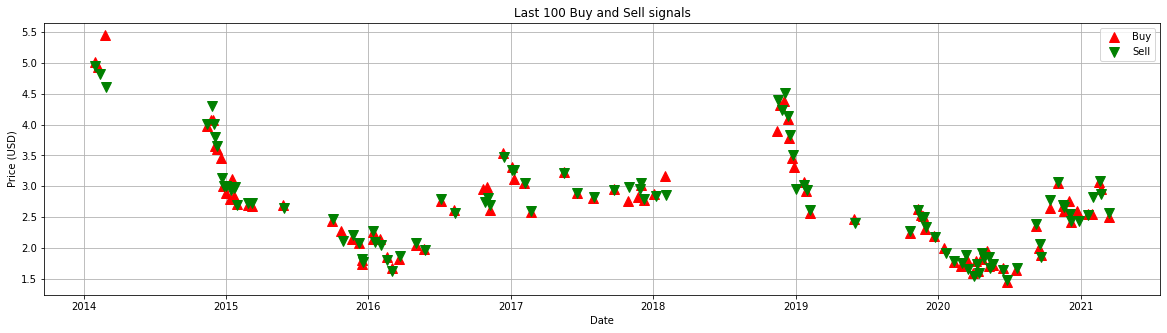

In [23]:
%matplotlib inline
print(MLDataFrame.PredictedSignal.value_counts())

# Buy/Sell signals plot
buys = MLDataFrame.loc[MLDataFrame["PredictedSignal"] == 1];
sells = MLDataFrame.loc[MLDataFrame["PredictedSignal"] == -1];
# Plot
fig = plt.figure(figsize=(20, 5));
# plt.plot(MLDataFrame.index[-100:], MLDataFrame['Close'][-100:], lw=2., label='Price');
# Plot buy and sell signals
# up arrow when we buy one share
plt.plot(buys.index[-100:], MLDataFrame.loc[buys.index]['Close'][-100:], '^', markersize=10, color='red', lw=2., label='Buy');
# down arrow when we sell one share
plt.plot(sells.index[-100:], MLDataFrame.loc[sells.index]['Close'][-100:], 'v', markersize = 10, color='green', lw=2., label='Sell');
plt.ylabel('Price (USD)'); plt.xlabel('Date');
plt.title('Last 100 Buy and Sell signals'); plt.legend(loc='best');
plt.grid(True)
plt.show()

We will initiate buy when volume is down and sell when volume is up

Starting Portfolio Value: 5000.0

2021-03-18: Close: $2.595, Position Size: 0
2021-01-19,BUY@ Price:     2.65, Cost:  4418.23, Comm:     4.42
2021-01-20,SELL CREATED --- Size: 1666
2021-01-20,SELL@ Price:     2.54, Cost:  4418.23, Comm    4.24
2021-01-29,BUY@ Price:     2.68, Cost:  4296.04, Comm:     4.30
2021-02-01,SELL CREATED --- Size: 1603
2021-02-01,SELL@ Price:     2.73, Cost:  4296.04, Comm    4.38
2021-02-16,SELL@ Price:     3.18, Cost:    -3.18, Comm    0.00
2021-02-16,Order Canceled/Margin/Rejected
2021-02-17,SELL@ Price:     3.22, Cost:    -3.22, Comm    0.00
2021-02-17,Order Canceled/Margin/Rejected
2021-02-19,SELL CREATED --- Size: -2
2021-02-19,SELL@ Price:     3.07, Cost:    -6.13, Comm    0.01
2021-02-23,SELL CREATED --- Size: -4
2021-02-23,SELL@ Price:     2.95, Cost:   -11.80, Comm    0.01
2021-03-16,SELL CREATED --- Size: -8
2021-03-16,SELL@ Price:     2.49, Cost:   -19.95, Comm    0.02

Trade Analysis Results:
                    Total Open          Total Closed   

<IPython.core.display.Javascript object>

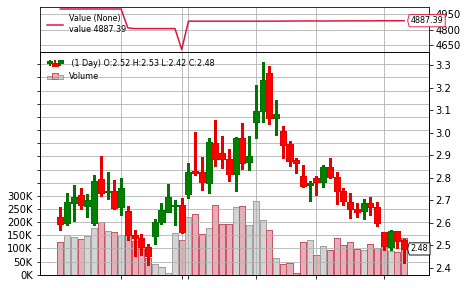

In [25]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

...
prices = MLDataFrame['2021-01-01':].copy()
OHLCV = ['Open', 'High', 'Low', 'Close', 'Volume']

...
# class to define the columns we will provide

class NaturalGasData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['PredictedSignal']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

...
# define backtesting strategy class

class NGStrategy(bt.Strategy):
    params = (
        ('percents', 0.9),
        ('stopLoss', 0.10), # if current price is %10 below the original buy price then sell the stock
        ('stopWin', 0.20) # if current price is %20 above the original buy price then sell the stock
    )
             # Float: 1 == 100%

    
    def __init__(self):
      # import ipdb; ipdb.set_trace()
      '''Initializes logger and variables required for the strategy implementation.'''
      # initialize logger for log function (set to critical to prevent any unwanted autologs, not using log objects because only care about logging one thing)
      
      for handler in logging.root.handlers[:]:
          logging.root.removeHandler(handler)

      logging.basicConfig(format='%(message)s', level=logging.CRITICAL, handlers=[
          logging.FileHandler("LOG.log"),
          logging.StreamHandler()
          ]
          )
      
      self.startCash = self.broker.getvalue()
            
      date = self.data.datetime.date()
      close = prices.Close[0]

      print('{}: Close: ${}, Position Size: {}'.format(date, close, self.position.size))

      # keep track of open, close prices and predicted value in the series
      self.data_PredictedSignal = self.datas[0].PredictedSignal
      self.data_Open = self.datas[0].Open
      self.data_Close = self.datas[0].Close

     # keep track of pending orders/buy price/buy commission
      
      self.order = None
      self.price = None
      self.stop_price = None
      self.comm = None
      self.trade = None
      self.buystop_order = None
      self.sellstop_order = None
      self.qty = 1

    # logging function

    """
    log function allows us to pass in data via the txt variable that we want to output to the screen. 
    It will attempt to grab datetime values from the most recent data point,if available, and log it to the screen.
    """
    
    def log(self, txt, doprint=True):
        '''Logging function'''
        # Logging function for the strategy.  'txt' is the statement and 'dt' can be used to specify a specific datetime
        dt = self.datas[0].datetime.date(0)
        print('{0},{1}'.format(dt.isoformat(), txt))
          
 
    def notify_order(self, order):
      date = self.data.datetime.date()

      """
      Run on every next iteration, logs the order execution status whenever an order is filled or rejected, 
      setting the order parameter back to None if the order is filled or cancelled to denote that there are no more pending orders.
      """
      # 1. If order is submitted/accepted, do nothing
      if order.status in [order.Submitted, order.Accepted]:
          return
      # 2. If order is buy/sell executed, report price executed
      if order.status == order.Completed:
          if order.isbuy():
              self.log('BUY@ Price: {0:8.2f}, Cost: {1:8.2f}, Comm: {2:8.2f}'.format(
                    order.executed.price,
                    order.executed.value,
                    order.executed.comm))
              
              self.buyprice = order.executed.price
              self.buycomm = order.executed.comm
            
          else:
            self.log('SELL@ Price: {0:8.2f}, Cost: {1:8.2f}, Comm{2:8.2f}'.format(
                    order.executed.price,
                    order.executed.value,
                    order.executed.comm))
            self.bar_executed = len(self)  # when was trade executed
            
      # 3. If order is canceled/margin/rejected, report order canceled
      elif order.status in [order.Canceled, order.Margin, order.Rejected]:
          self.log('Order Canceled/Margin/Rejected')

      """
      When system receives a buy or sell signal, we can instruct it to create an order. 
      However, that order won’t be executed until the next bar is called, at whatever price that may be.
      """
   

      """
      automate stop loss and stop profit based on a percentage from the original buy price,
      """
      
      if order.status in [order.Completed]:
            if order.isbuy():
                if(self.params.stopLoss):
                    self.stopOrder = self.sell(price=order.executed.price,exectype=bt.Order.StopTrail,trailpercent=self.params.stopLoss)

                if(self.params.stopWin):
                    self.stopOrder = self.sell(price=(order.executed.price*(1+self.params.stopWin)),exectype=bt.Order.Limit,oco=self.stopOrder)
      # set no pending order
      self.order = None

    """
      In below we will overwrite is the notify_trade function and here everything related to trade orders gets processed.
      This will log when an order gets executed, and at what price. This will also provide notification in case an order didn’t go through.
    """
    
    def notify_trade(self, trade):
        date = self.data.datetime.date()
        if not trade.isclosed:
          return
          self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    """
        As we have predicted the market direction on the day’s closing price, hence we will use cheat_on_open=True 
        when creating the bt.Cerebro object. This means the number of shares we want to buy will be based on day t+1’s open price. 
        As a result, we also define the next_open method instead of next within the Strategy class.
    """

    def next_open(self):
        if self.order:  # check if order is pending, if so, then break out
            return

      # since there is no order pending, are we in the market?
        if not self.position:
            if self.data_PredictedSignal == -1:
                size = int(self.broker.getcash() / self.datas[0].Open)
                self.buy(size=size)
        else:
            if self.data_PredictedSignal == 1:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

class Test(unittest.TestCase):
  def setUp(self):
    self.trading_strategy= NGStrategy()


def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in tabular format.
    '''
    # Get the results we are interested in
    totalOpen = analyzer.total.open
    totalClosed = analyzer.total.closed
    totalWon = analyzer.won.total
    totalLost = analyzer.lost.total
    winStreak = analyzer.streak.won.longest
    loseStreak = analyzer.streak.lost.longest
    pnlNet = round(analyzer.pnl.net.total,2)
    strikeRate = (totalWon / totalClosed) * 100
    
    # Designate the rows
    a = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    b = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    c = [totalOpen, totalClosed,totalWon,totalLost]
    d = [strikeRate, winStreak, loseStreak, pnlNet]
    
    # Check which set of headers is the longest.
    if len(a) > len(b):
        header_length = len(a)
    else:
        header_length = len(b)
    
    # Print the rows
    print_list = [a,b,c,d]
    row_format ="{:<20}" * (header_length + 1)
    
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))
 
def printSQN(analyzer):
    sqn = round(analyzer.sqn,2)
    print('SQN: {}'.format(sqn))

...
# instantiate SignalData class

data = NaturalGasData(dataname=prices)

def runstrat():

    # Variable for our starting cash

    startCash = 5000.0

    NGtrade = bt.Cerebro(stdstats = False, cheat_on_open=True, maxcpus=1)
    NGtrade.addstrategy(NGStrategy)
    NGtrade.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    # Add the analyzers we are interested in
    NGtrade.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    NGtrade.addanalyzer(bt.analyzers.SQN, _name="sqn")
    NGtrade.addobserver(bt.observers.Value)
    NGtrade.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    NGtrade.addanalyzer(bt.analyzers.Returns)
    NGtrade.addanalyzer(bt.analyzers.DrawDown)
    
    NGtrade.adddata(data)

    # Set desired cash start

    NGtrade.broker.setcash(startCash)
    NGtrade.broker.setcommission(commission=0.001)
    
    startPortfolioValue = NGtrade.broker.getvalue()
    print('Starting Portfolio Value:', startPortfolioValue)
    print()
    
    strategies = NGtrade.run(runonce=False)

    firstStrat = strategies[0]

    # print the analyzers
    print()
    printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
    printSQN(firstStrat.analyzers.sqn.get_analysis())

    # Get final portfolio Value
    endPortfolioValue = NGtrade.broker.getvalue()
    print()
    print(f'Final Portfolio Value: {endPortfolioValue:.2f}')
        
    pnl = endPortfolioValue - startPortfolioValue
    print()
    print(f'PnL: {pnl:.2f}') 


    NGtrade.plot(style='candlestick', barup='green', bardown='red',
                 subtxtsize=8)[0][0].savefig('samplefigure.png', dpi=300)
    #files.download('samplefigure.png')


if __name__ == '__main__':
  runstrat()
